# Consumer complaint classification

In this part we'll try to solve a multiclassification problem for text data in Python namely solving Consumer complaint classification for the finance industry.

# 1. Exploring and understanding dataset

We employ a large data collection from Kaggle website containing description complaints. The dataset can be found at the following url: https://www.kaggle.com/subhassing/exploring-consumer-complaint-data/data

In [84]:
# import required libraries
import pandas as pd
import numpy as np
from io import StringIO
import string
import os

from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

from textblob import TextBlob
from textblob import Word

import sklearn.feature_extraction as text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [85]:
# import dataset into pandas DataFrame
df = pd.read_csv('./dataset/consumer_complaints.csv', encoding='latin-1')

/home/dacy/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [86]:
# read the first 5 occurences of dataset
df.head()

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067


In [87]:
# check dataset columns
df.columns

Index(['date_received', 'product', 'sub_product', 'issue', 'sub_issue',
       'consumer_complaint_narrative', 'company_public_response', 'company',
       'state', 'zipcode', 'tags', 'consumer_consent_provided',
       'submitted_via', 'date_sent_to_company', 'company_response_to_consumer',
       'timely_response', 'consumer_disputed?', 'complaint_id'],
      dtype='object')

In [88]:
# check number of records and columns in the dataset
df.shape

(555957, 18)

We can see that we are dealing with more than 500.000 records on consumer complaints data and 18 features or columns.

In [89]:
# select required columns and rows
df = df[['product', 'consumer_complaint_narrative']]

In [90]:
# check the newly created DataFrame
df.head()

,product,consumer_complaint_narrative
0,Mortgage,NaN
1,Mortgage,NaN
2,Credit reporting,NaN
3,Student loan,NaN
4,Debt collection,NaN


In [91]:
# get all non-null records from 'consumer_complaint_narrative' feature/column name
df = df[pd.notnull(df['consumer_complaint_narrative'])]

In [92]:
# check the first 10 entries
df.head(10)

,product,consumer_complaint_narrative
190126,Debt collection,XXXX has claimed I owe them {$27.00} for XXXX ...
190135,Consumer Loan,Due to inconsistencies in the amount owed that...
190155,Mortgage,In XX/XX/XXXX my wages that I earned at my job...
190207,Mortgage,I have an open and current mortgage with Chase...
190208,Mortgage,XXXX was submitted XX/XX/XXXX. At the time I s...
190237,Mortgage,Experian is reporting my OPEN and CURRENT Mort...
190238,Mortgage,This complaint is against Wells Fargo Bank for...
190251,Mortgage,I spoke to XXXX of green tree representatives ...
190263,Credit card,i opened XXXX Bank of America credit cards 15-...
190264,Consumer Loan,I applied for a loan with XXXX XXXX and had pu...


Looking at the newly generated DataFrame, we can see that now we have text data in the 'consumer_complaint_narrative' column.

In [93]:
# factorizing the category column
df['category_id'] = df['product'].factorize()[0]

In [94]:
# check DataFrame
df.head()

,product,consumer_complaint_narrative,category_id
190126,Debt collection,XXXX has claimed I owe them {$27.00} for XXXX ...,0
190135,Consumer Loan,Due to inconsistencies in the amount owed that...,1
190155,Mortgage,In XX/XX/XXXX my wages that I earned at my job...,2
190207,Mortgage,I have an open and current mortgage with Chase...,2
190208,Mortgage,XXXX was submitted XX/XX/XXXX. At the time I s...,2


In [95]:
# check distribution count of complaints by category
df.groupby('product').consumer_complaint_narrative.count()

product
Bank account or service     5711
Consumer Loan               3678
Credit card                 7929
Credit reporting           12526
Debt collection            17552
Money transfers              666
Mortgage                   14919
Other financial service      110
Payday loan                  726
Prepaid card                 861
Student loan                2128
Name: consumer_complaint_narrative, dtype: int64

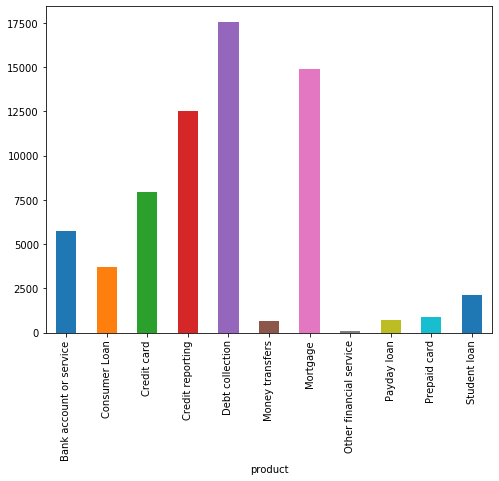

In [96]:
# plot distribution count using matplotlib 
fig = plt.figure(figsize=(8,6))
df.groupby('product').consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

From the generated plot distribution we can see that Debt Collection and Mortgage have the highest number of complaints registered.

# 2. Feature Engineering

In [97]:
# next, split dataset into training and validation using sklearn
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(df['consumer_complaint_narrative'], df['product'])

In [98]:
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

In [99]:
# create TF-IDF object with maximum 5000 features
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)

In [100]:
tfidf_vect.fit(df['consumer_complaint_narrative'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=5000,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='\\w{1,}', tokenizer=None,
                use_idf=True, vocabulary=None)

In [101]:
xtrain_tfidf = tfidf_vect.transform(train_x)

In [102]:
xvalid_tfidf = tfidf_vect.transform(valid_x)

# 3. Model building and evaluation

In [103]:
# create a linear classifier on word-level TF-IDF using default hyperparameters
model = linear_model.LogisticRegression().fit(xtrain_tfidf, train_y)

/home/dacy/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dacy/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [104]:
# model summary
model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [105]:
# print accuracy model
prediction = model.predict(xvalid_tfidf)
accuracy = metrics.accuracy_score(prediction, valid_y)
print("Accuracy: ", accuracy)

Accuracy:  0.8430726859058796


In [106]:
# get classification report
print(metrics.classification_report(valid_y, prediction,target_names=df['product'].unique()))

                         precision    recall  f1-score   support

        Debt collection       0.82      0.80      0.81      1465
          Consumer Loan       0.78      0.57      0.66       914
               Mortgage       0.80      0.82      0.81      1991
            Credit card       0.84      0.86      0.85      3071
       Credit reporting       0.81      0.89      0.85      4337
           Student loan       0.75      0.47      0.57       172
Bank account or service       0.92      0.95      0.94      3724
            Payday loan       0.00      0.00      0.00        27
        Money transfers       0.61      0.18      0.28       209
Other financial service       0.81      0.64      0.71       222
           Prepaid card       0.91      0.79      0.85       570

               accuracy                           0.84     16702
              macro avg       0.73      0.63      0.67     16702
           weighted avg       0.84      0.84      0.84     16702



/home/dacy/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [107]:
# get confusion matrix
conf_mat = confusion_matrix(valid_y, prediction)

In [108]:
# visualizing confusion matrix
category_id_df = df[['product', 'category_id']].drop_duplicates().sort_values('category_id')

In [109]:
category_id = dict(category_id_df.values)

In [110]:
category_id

{'Debt collection': 0,
 'Consumer Loan': 1,
 'Mortgage': 2,
 'Credit card': 3,
 'Credit reporting': 4,
 'Student loan': 5,
 'Bank account or service': 6,
 'Payday loan': 7,
 'Money transfers': 8,
 'Other financial service': 9,
 'Prepaid card': 10}

In [111]:
category_id_df[['category_id', 'product']].values

array([[0, 'Debt collection'],
       [1, 'Consumer Loan'],
       [2, 'Mortgage'],
       [3, 'Credit card'],
       [4, 'Credit reporting'],
       [5, 'Student loan'],
       [6, 'Bank account or service'],
       [7, 'Payday loan'],
       [8, 'Money transfers'],
       [9, 'Other financial service'],
       [10, 'Prepaid card']], dtype=object)

In [112]:
id_to_category = dict(category_id_df[['category_id', 'product']].values)

In [113]:
id_to_category

{0: 'Debt collection',
 1: 'Consumer Loan',
 2: 'Mortgage',
 3: 'Credit card',
 4: 'Credit reporting',
 5: 'Student loan',
 6: 'Bank account or service',
 7: 'Payday loan',
 8: 'Money transfers',
 9: 'Other financial service',
 10: 'Prepaid card'}

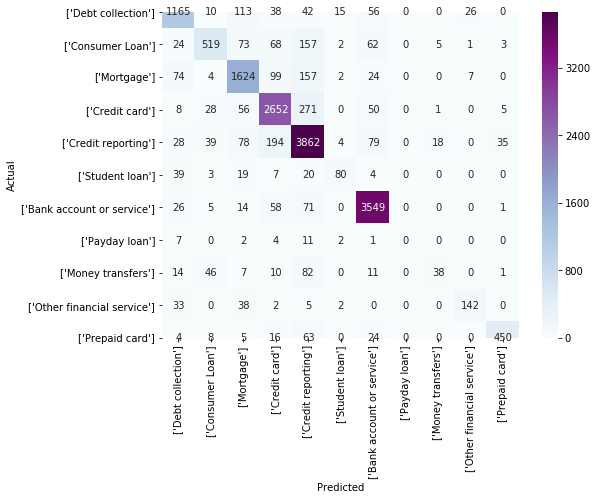

In [114]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, 
            annot=True, 
            fmt='d', 
            cmap="BuPu", 
            xticklabels=category_id_df[['product']].values, 
            yticklabels=category_id_df[['product']].values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 4. Prediction

In [115]:
# prediction example
texts = ["This company refuses to provide me verification and validation of debt", "I applied for a loan with XXXX XXXX and had"]

In [116]:
text_features = tfidf_vect.transform(texts)

In [117]:
text_features

<2x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 20 stored elements in Compressed Sparse Row format>

In [118]:
predictions = model.predict(text_features)

In [119]:
print(texts)
print(" - Prediction sent1 as: '{}'".format(id_to_category[predictions[0]]))
print(" - Prediction sent2 as: '{}'".format(id_to_category[predictions[1]]))

['This company refuses to provide me verification and validation of debt', 'I applied for a loan with XXXX XXXX and had']
 - Prediction sent1 as: 'Credit reporting'
 - Prediction sent2 as: 'Bank account or service'
